In [1]:
#import statements 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:

#links to data
#Doron: https://www.science.org/doi/suppl/10.1126/science.aar4120/suppl_file/aar4120_tabless1-s5.xlsx 
#Blasks: 

#known defence families 
Doron1 = pd.read_excel('aar4120_tabless1-s5.xlsx', sheet_name = 'S1 - Known defense families' )
#putative denfence systems 
Doron3 = pd.read_excel('aar4120_tabless1-s5.xlsx', sheet_name = 'S3 - candidate systems')
#Cycog annotations 
blasks = pd.read_csv('./cycog_annotations.csv')
#MED 4 mapping
med4_mapping = pd.read_csv('.\MED4_cycog6_table.tsv',
                      names = ['Gene Name', 'MED4', 'CyCOG'],
                      sep = '\t')
#potentially upregulated genes
pmm_genes = pd.read_csv('./pmm-genes.csv',
                       names = ['pmm_gene'])

#cluster 2 from virus hotspot 
cluster_2 = pd.read_excel('S1_File-Pro-Clusters.xlsx', sheet_name='pro2-gene-weights')


print(len(Doron3))
print(len(Doron1))
print(len(blasks))

41
427
40295


In [3]:
#create properly formatted master Doron table 

#preprocess Doron 3 by splitting rows with miltiple family IDS into their own row
index_to_drop = []
rows_to_add = pd.DataFrame(columns=Doron3.columns)
for i,r in Doron3.iterrows():
    ids = r['Anchor protein families'].split(';')
    if len(ids) > 1:
        index_to_drop.append(i)
        for id in ids:
            new_row = r.copy()
            new_row['Anchor protein families'] = id
            rows_to_add.loc[len(rows_to_add.index)] = new_row
Doron3 = Doron3.drop(index = index_to_drop)
Doron3 = pd.concat([Doron3, rows_to_add])
Doron3 = Doron3.rename(columns={'Anchor protein families':'Family'})
Doron3.head()
print(len(Doron3))
#create one master doron df
Doron = pd.concat([Doron1, Doron3])
print(len(Doron))
#de-duplicate
Doron = Doron.drop_duplicates(subset=['Family'])
print(len(Doron))

58
485
460


In [4]:
#reformatting to match other datatables
med4_mapping['CyCOG'] = med4_mapping['CyCOG'].str.replace("CyCOG_", '').astype('int64')
med4_mapping['CyCOG'].dtype

dtype('int64')

In [5]:
# matching each putative antiphage defense system with it's corresponding CyCOG(s)

#filter blasks so that only those pfamIDS which 
#correspond to putative antiphage defence systems are kept 
filtered_blasks = blasks.dropna(subset=['PfamID'])
filtered_blasks = filtered_blasks[filtered_blasks['PfamID'].isin(Doron['Family'])]

#joining filtered blasks with Doron data
blasks_filtered_full = filtered_blasks
blasks_filtered_full = blasks_filtered_full.rename(columns={'PfamID':'Family'})
blasks_filtered_full = pd.merge(blasks_filtered_full, Doron, how='left', on='Family')

In [6]:
#remove entries from cluster 2 where there is less than 50% bootstrap 
cluster_2 = cluster_2[cluster_2['BootstrapSupport'] > 0.5]
cluster_2

,Ortholog,MedianWeight,MeanWeight,BootstrapSupport,Annotation
0,60001478,0.225654,0.222134,0.990000,hypothetical protein
1,60002435,0.222916,0.214701,1.000000,type I restriction enzyme M protein
2,60002260,0.216341,0.208911,0.983333,autotransporter-associated beta strand repeat-...
3,60003365,0.213002,0.205444,0.990000,hypothetical protein
4,60001376,0.194426,0.188671,0.993333,Tetratricopeptide repeat-containing protein
...,...,...,...,...,...
95,60001776,0.001909,0.007046,0.563333,hypothetical protein
96,60000015,0.001686,0.015031,0.520000,"dTDP-4-amino-4,6-dideoxygalactose transaminase"
97,60000962,0.001673,0.007640,0.540000,glycyl-tRNA synthetase alpha chain
98,60002244,0.000668,0.019127,0.510000,hypothetical protein


In [7]:
# calucating the % of cyanobacteria refs and  % viral ref for each cycog
cluster_2["cyanobacteria_%"] = None
cluster_2["viral_%"] = None
cluster_2["ratio"] = None

for index, row in cluster_2.iterrows():
    blasks_row = blasks[blasks['CyCOGID']==row['Ortholog']]
    #if it's not an artifact, so has more than 5 refences, calculate the percentage of viral references present
    if blasks_row['TotalRefs'].iloc[0] > 5:
        cyano = float(((blasks_row['Prochlorococcus'] + blasks_row['Synechococcus'])/blasks_row['TotalRefs'])*100)
        viral = float((blasks_row['Virus']/blasks_row['TotalRefs'])*100)
        #ratio is viral/(viral+cyanobacteria)
        ratio = float((blasks_row['Virus']/(blasks_row['Virus'] + blasks_row['Prochlorococcus'] + blasks_row['Synechococcus']))*100)
        cluster_2.iloc[index, 5] = cyano
        cluster_2.iloc[index, 6] = viral
        cluster_2.iloc[index, 7] = ratio
    else: 
        cluster_2.iloc[index, 5] = None
        cluster_2.iloc[index, 6] = None
        cluster_2.iloc[index, 7] = None


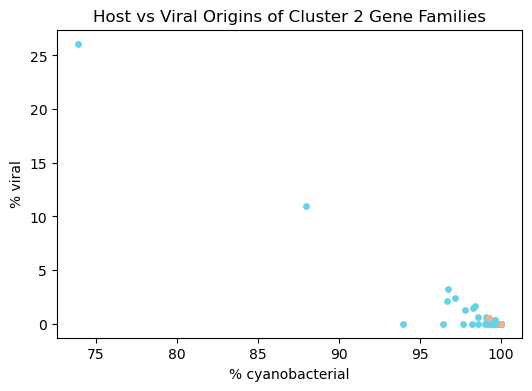

In [8]:
#plotting scatterplot

plt.figure(figsize=(6, 4))

plt.scatter(cluster_2['cyanobacteria_%'], 
            cluster_2['viral_%'],
            s=15,
            color = '#64D2EA')
#highlighting the 2 cycogs repping the RM system whichhave 100% cyano refs 
plt.scatter(100, 0, s=15, color='#FAAF84')
#highlighting the cycog that related to elevated expression in MED4 viral treatment 
plt.scatter(99.260042,0.528541,s=15,color="#FAAF84")

plt.title('Host vs Viral Origins of Cluster 2 Gene Families')
plt.xlabel('% cyanobacterial')
plt.ylabel('% viral')
plt.show()

^In the future, would it be worth exploring the data where there is 0% viral refs but not 100% cyanobacterial refs, bc the rest of the % would be sourced from virocells

In [9]:
#check which genes in cluster are aldo in Doron et al.
defense_cycogs_from_clusters = cluster_2[cluster_2['Ortholog'].isin(blasks_filtered_full['CyCOGID'])]
defense_cycogs_from_clusters

,Ortholog,MedianWeight,MeanWeight,BootstrapSupport,Annotation,cyanobacteria_%,viral_%,ratio
1,60002435,0.222916,0.214701,1.000000,type I restriction enzyme M protein,100.0,0.0,0.0
10,60003220,0.158392,0.155704,0.993333,"type I restriction enzyme, R subunit",100.0,0.0,0.0
74,60007217,0.020211,0.027991,0.596667,ATP-dependent Lon protease,None,None,None
86,60002766,0.009283,0.032902,0.530000,Helicase conserved C-terminal domain-containin...,100.0,0.0,0.0


In [10]:
#cluster2 cycogs that map to med4
Cluster_mapping = cluster_2[cluster_2['Ortholog'].isin(med4_mapping['CyCOG'])]
Cluster_mapping = Cluster_mapping.rename(columns={'Ortholog':'CyCOG'})
Cluster_mapping = Cluster_mapping.merge(med4_mapping, on='CyCOG')
#check which of these are in the lab expression dataset 
pmm_check = Cluster_mapping[Cluster_mapping['Gene Name'].isin(pmm_genes['pmm_gene'])]
pmm_check

int64
int64


,CyCOG,MedianWeight,MeanWeight,BootstrapSupport,Annotation,cyanobacteria_%,viral_%,ratio,Gene Name,MED4
2,60001223,0.140853,0.126768,0.900000,"ATP-binding cassette, subfamily B",99.805068,0.0,0.0,PMM1239,MED4_2606840707
7,60001593,0.134061,0.126671,0.976667,carbamoyltransferase,87.985866,10.954064,11.071429,PMM1246,MED4_2606840715
8,60001593,0.134061,0.126671,0.976667,carbamoyltransferase,87.985866,10.954064,11.071429,PMM1251,MED4_2606840720
10,60000046,0.108792,0.105690,0.980000,UDP-glucuronate 4-epimerase,99.260042,0.528541,0.529661,PMM1201,MED4_2606840669
12,60000046,0.108792,0.105690,0.980000,UDP-glucuronate 4-epimerase,99.260042,0.528541,0.529661,PMM1210,MED4_2606840678
40,60000015,0.001686,0.015031,0.520000,"dTDP-4-amino-4,6-dideoxygalactose transaminase",99.334601,0.285171,0.28626,PMM1205,MED4_2606840673


row relating to PMM1205, only hour 36 is uplegulated and relevant but bc all the other p values are >0.05 and they're over and uderegulated, should we disreguard this?
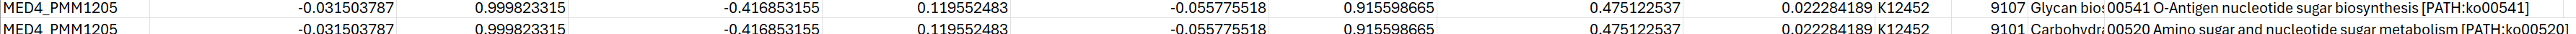

Text(0, 0.5, 'Log 2-Fold Change')

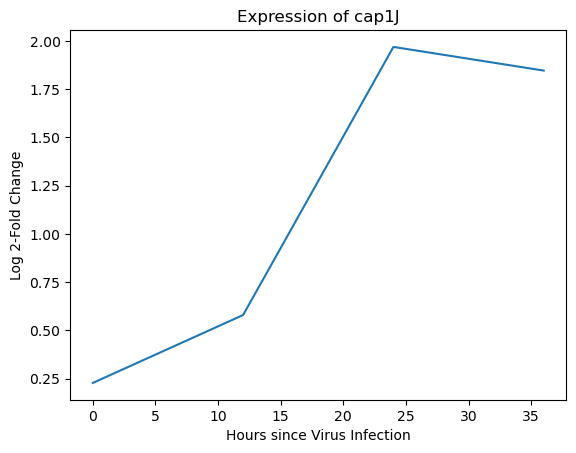

In [11]:
#creating graph of expression over time of gene PMM1201 
x = [0, 12, 24, 36]
y = [0.228027055, 0.579989392, 1.969209178, 1.846609144]
sns.lineplot(x=x,y=y)
plt.title('Expression of cap1J')
plt.xlabel('Hours since Virus Infection')
plt.ylabel('Log 2-Fold Change')


In [12]:
#checking for that S subunit
pfam2cycog = blasks[blasks['PfamID'] == 'pfam01420']
cluster_2[cluster_2['Ortholog'].isin(pfam2cycog['CyCOGID'])]

int64
int64


,Ortholog,MedianWeight,MeanWeight,BootstrapSupport,Annotation,cyanobacteria_%,viral_%,ratio


In [13]:
#Defense systems counts for Doron 
ds_counts = pd.DataFrame(Doron['Defense system type'].value_counts())
ds_counts.head()
ds_counts.reset_index(inplace=True)
ds_counts.rename(columns={'index':'Defense system type','Defense system type':'counts'}, inplace=True)
ds_counts = ds_counts[ds_counts['counts'] > 1]

#Defense system sounts for CyCOGS
ds_blasks_counts = pd.DataFrame(blasks_filtered_full['Defense system type'].value_counts())
ds_blasks_counts.head()
ds_blasks_counts.reset_index(inplace=True)
ds_blasks_counts.rename(columns={'index':'Defense system type','Defense system type':'counts'}, inplace=True)
ds_blasks_counts = ds_blasks_counts[ds_blasks_counts['counts'] > 1]

#merge into one DataFrame 
ds_counts_all = ds_counts.merge(ds_blasks_counts, on='Defense system type')
ds_counts_all = ds_counts_all.rename(columns={'counts_x': 'Doron', 'counts_y': 'Blaskowski'})
ds_counts_all

,Defense system type,Doron,Blaskowski
0,TA,130,101
1,RM,99,145
2,CRISPR,72,19
3,BREX,11,20
4,DISARM-associated,10,27
5,new_RM,8,3
6,Zorya,8,15
7,DISARM,4,42
8,"System around anchors pfam06634, COG1483",3,3
9,Septu+System around anchor pfam12476,2,2


<function matplotlib.pyplot.show(close=None, block=None)>

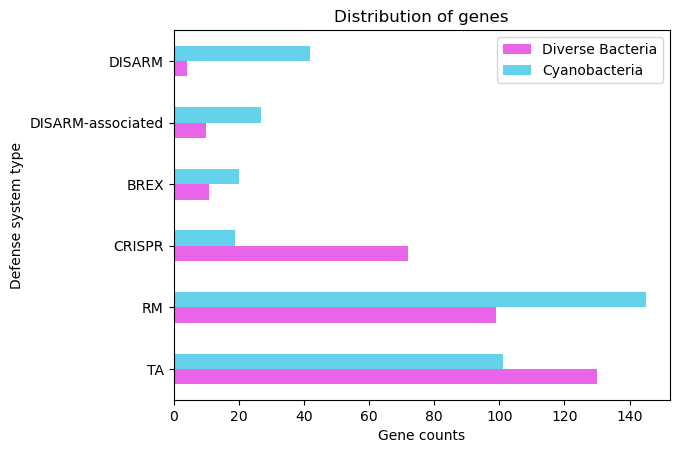

In [14]:
#filter so if there's less than 15 genes in blasks, its dropped

ds_all_top_counts = ds_counts_all[ds_counts_all['Blaskowski']>15]
ds_all_top_counts

#side-by-side Doron et al. & Cycogs Defense system type dist barplot
ds_all_top_counts.plot.barh(x='Defense system type', color=['#EA64EA','#64D2EA'])
plt.xlabel("Gene counts")
plt.title('Distribution of genes')
plt.legend(['Diverse Bacteria', 'Cyanobacteria'])

plt.show

In [15]:
blasks_filtered_full[blasks_filtered_full['CyCOGID'] == 60002766]
#meets Doron Threshold: variability > 0.1 and defense score > 0.65

,CyCOGID,TotalRefs,Prochlorococcus,Synechococcus,Virocell,Virus,5.1A-CRD2,5.1A-II,5.1A-III,5.1A-IV,...,NRefsOtherPfam,Used in prediction cycle #,Source,Defense system type,Annotation / Comments,Defense score,Variability score,number of genes?,Included/Excluded from experimental study,Reason for exclusion
25,60002766,59,50,9,0,0,0,2,0,3,...,24.0,2.0,known system found in round 1,RM,maybe a type IIG gene; Restriction endonuclease,0.824993,0.186648,NaN,NaN,NaN
